In [ ]:
# Install Rasterio and related tools (only needed once in Colab)
!pip install rasterio
!pip install geopandas
!pip install torch torchvision torchaudio
!pip install torchgeo
!pip install matplotlib scikit-learn

# Import libraries
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.enums import Resampling


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# Define bounding box (longitude and latitude)
aoi = {
    'min_lon': 73.70,
    'max_lon': 73.80,
    'min_lat': 20.00,
    'max_lat': 20.10
}


In [ ]:
import requests

# Nashik is in tile N20E073 (based on SRTM naming scheme)
tile_name = "N20E073"
tile_url = f"https://s3.amazonaws.com/elevation-tiles-prod/skadi/N20/{tile_name}.hgt.gz"
output_file = f"{tile_name}.hgt.gz"

# Download tile
if not os.path.exists(output_file):
    print("Downloading SRTM tile...")
    response = requests.get(tile_url)
    with open(output_file, "wb") as f:
        f.write(response.content)
    print("Download complete.")
else:
    print("File already downloaded.")


Download complete.


In [ ]:
import gzip
import shutil
from osgeo import gdal

# Step 1: Unzip .hgt.gz file
hgt_file = tile_name + ".hgt"
if not os.path.exists(hgt_file):
    with gzip.open(output_file, 'rb') as f_in:
        with open(hgt_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Unzipped to: {hgt_file}")
else:
    print(f"{hgt_file} already exists.")

# Step 2: Convert .hgt to GeoTIFF using GDAL
tif_file = tile_name + ".tif"
if not os.path.exists(tif_file):
    ds = gdal.Open(hgt_file)
    gdal.Translate(tif_file, ds)
    print(f"Converted to GeoTIFF: {tif_file}")
else:
    print(f"{tif_file} already exists.")


Unzipped to: N20E073.hgt
Converted to GeoTIFF: N20E073.tif


/usr/local/lib/python3.11/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [ ]:
from rasterio.transform import from_origin
from rasterio.warp import transform_bounds

# Open the full DEM GeoTIFF
src = rasterio.open(tif_file)

# Transform AOI coordinates (lat/lon) to the raster's CRS (usually EPSG:4326 for SRTM)
bounds = transform_bounds('EPSG:4326', src.crs,
                          aoi['min_lon'], aoi['min_lat'],
                          aoi['max_lon'], aoi['max_lat'])

# Define a rasterio window from AOI bounds
window = from_bounds(*bounds, transform=src.transform)

# Read the clipped DEM
dem = src.read(1, window=window)
transform = src.window_transform(window)

# Mask invalid values (SRTM uses -32768 for no data)
dem = np.where(dem == -32768, np.nan, dem)


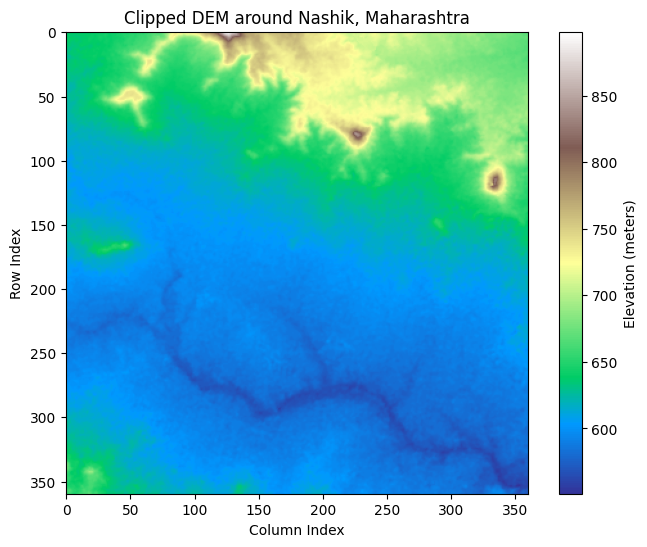

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(dem, cmap='terrain')
plt.colorbar(label='Elevation (meters)')
plt.title('Clipped DEM around Nashik, Maharashtra')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


In [ ]:
# Define flood-prone threshold — say, elevation < 550m is considered flood-prone
threshold = 550  # meters

# Create binary label array: 1 for flood-prone, 0 for safe
labels = np.where(dem < threshold, 1, 0)


In [ ]:
# Print basic statistics of the DEM
print(f"Min elevation: {np.nanmin(dem):.2f} m")
print(f"Max elevation: {np.nanmax(dem):.2f} m")
print(f"Mean elevation: {np.nanmean(dem):.2f} m")


Min elevation: 551.00 m
Max elevation: 898.00 m
Mean elevation: 622.92 m


In [ ]:
# Let's set threshold to bottom 25% of elevation values (dynamic)
elev_threshold = np.nanpercentile(dem, 25)

print(f"25th percentile elevation = {elev_threshold:.2f} m")

# Recalculate labels
labels = np.where(dem < elev_threshold, 1, 0)


25th percentile elevation = 592.00 m


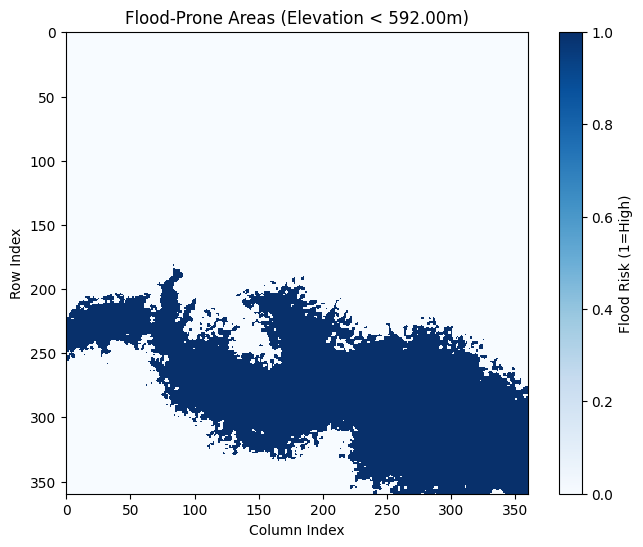

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(labels, cmap='Blues', interpolation='none')
plt.title(f'Flood-Prone Areas (Elevation < {elev_threshold:.2f}m)')
plt.colorbar(label='Flood Risk (1=High)')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


In [ ]:
import torch
from sklearn.model_selection import train_test_split

# Step 1: Flatten DEM and labels
X = dem.flatten().reshape(-1, 1)  # Shape: (num_pixels, 1 feature)
y = labels.flatten()             # Shape: (num_pixels,)

# Remove NaNs (invalid elevation values)
mask = ~np.isnan(X[:, 0])
X_clean = X[mask]
y_clean = y[mask]


In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Wrap in a PyTorch dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Define a simple neural network
class FloodNet(nn.Module):
    def __init__(self):
        super(FloodNet, self).__init__()
        self.fc1 = nn.Linear(1, 16)     # Input layer → Hidden
        self.fc2 = nn.Linear(16, 2)     # Hidden layer → Output (2 classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))         # Apply ReLU to hidden layer
        x = self.fc2(x)                 # Output layer (raw scores)
        return x


In [ ]:
model = FloodNet()

# Loss function: CrossEntropyLoss (good for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam (adaptive learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()            # Clear previous gradients
        outputs = model(batch_X)         # Forward pass
        loss = criterion(outputs, batch_y)  # Compute loss
        loss.backward()                  # Backpropagation
        optimizer.step()                 # Update weights

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Epoch [1/20] Loss: 1.0865
Epoch [2/20] Loss: 0.6466
Epoch [3/20] Loss: 0.5556
Epoch [4/20] Loss: 0.4947
Epoch [5/20] Loss: 0.4478
Epoch [6/20] Loss: 0.4179
Epoch [7/20] Loss: 0.3991
Epoch [8/20] Loss: 0.3818
Epoch [9/20] Loss: 0.3651
Epoch [10/20] Loss: 0.3516
Epoch [11/20] Loss: 0.3386
Epoch [12/20] Loss: 0.3304
Epoch [13/20] Loss: 0.3201
Epoch [14/20] Loss: 0.3082
Epoch [15/20] Loss: 0.3003
Epoch [16/20] Loss: 0.2929
Epoch [17/20] Loss: 0.2888
Epoch [18/20] Loss: 0.2751
Epoch [19/20] Loss: 0.2718
Epoch [20/20] Loss: 0.2628


In [ ]:
model.eval()  # Set model to evaluation mode

all_preds = []
all_targets = []

with torch.no_grad():  # No need to compute gradients during evaluation
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)              # Forward pass
        _, predicted = torch.max(outputs, 1)  # Take class with max logit
        all_preds.append(predicted.numpy())
        all_targets.append(batch_y.numpy())

# Concatenate batches
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)


Test Accuracy: 0.8747
Confusion Matrix:
 [[19570     0]
 [ 3247  3103]]


In [ ]:
# Prepare full prediction map (same shape as original DEM)
flat_pred_map = np.full(dem.size, np.nan)  # Start with all NaNs

# Insert predicted values back into valid (non-NaN) positions
flat_pred_map[mask] = model(torch.tensor(X_clean, dtype=torch.float32)).argmax(dim=1).numpy()

# Reshape back to original image shape
predicted_map = flat_pred_map.reshape(dem.shape)


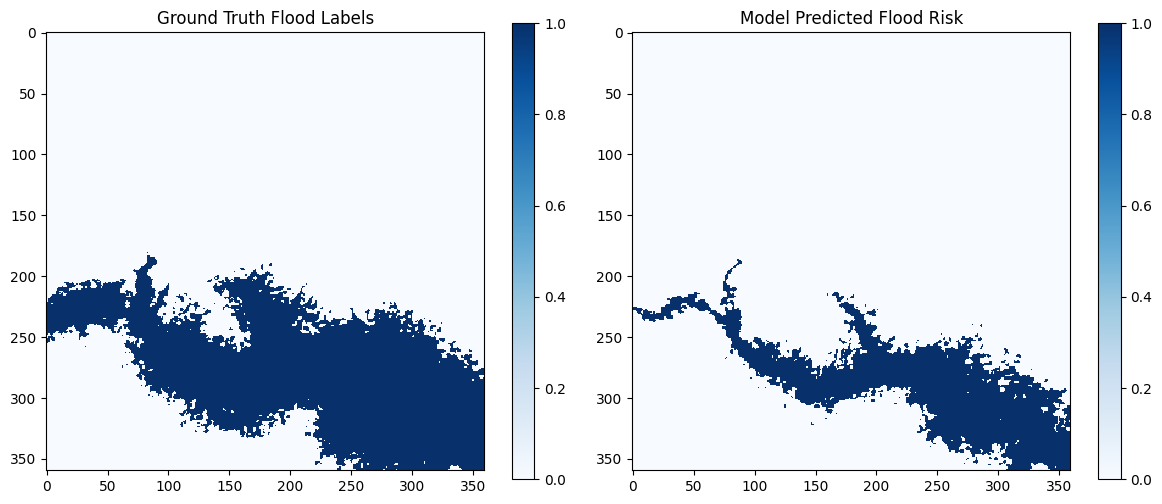

In [ ]:
plt.figure(figsize=(12, 5))

# Ground truth
plt.subplot(1, 2, 1)
plt.imshow(labels, cmap='Blues', interpolation='none')
plt.title("Ground Truth Flood Labels")
plt.colorbar()

# Prediction
plt.subplot(1, 2, 2)
plt.imshow(predicted_map, cmap='Blues', interpolation='none')
plt.title("Model Predicted Flood Risk")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
# Define pixel size (SRTM = ~30 meters)
pixel_size = 30  # meters

# Calculate slope using central difference
def calculate_slope(dem, pixel_size):
    # Vertical and horizontal gradients
    dzdx = (np.roll(dem, -1, axis=1) - np.roll(dem, 1, axis=1)) / (2 * pixel_size)
    dzdy = (np.roll(dem, -1, axis=0) - np.roll(dem, 1, axis=0)) / (2 * pixel_size)

    # Slope magnitude (rise/run)
    slope = np.sqrt(dzdx**2 + dzdy**2)
    return slope

slope = calculate_slope(dem, pixel_size)

# Mask NaNs
slope = np.where(np.isnan(dem), np.nan, slope)


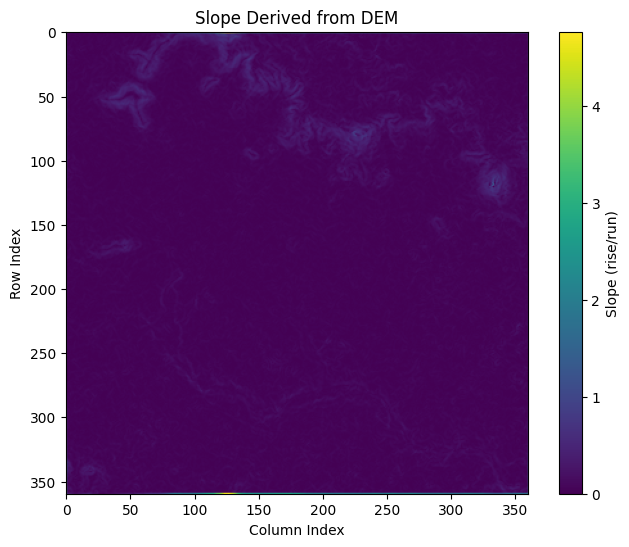

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(slope, cmap='viridis')
plt.colorbar(label='Slope (rise/run)')
plt.title('Slope Derived from DEM')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()


In [ ]:
# Flatten slope and remove NaNs alongside DEM
slope_flat = slope.flatten().reshape(-1, 1)

# Only keep samples where both elevation and slope are valid
valid_mask = ~np.isnan(X[:, 0]) & ~np.isnan(slope_flat[:, 0])

# Stack features: [elevation, slope]
X_combined = np.hstack([X[valid_mask], slope_flat[valid_mask]])
y_combined = y[valid_mask]


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create new datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# New model with 2 input features
class FloodNetV2(nn.Module):
    def __init__(self):
        super(FloodNetV2, self).__init__()
        self.fc1 = nn.Linear(2, 16)     # Now input size is 2 (elevation + slope)
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and train same as before
model = FloodNetV2()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Training loop (same as before)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Epoch [1/20] Loss: 0.7096
Epoch [2/20] Loss: 0.5364
Epoch [3/20] Loss: 0.4706
Epoch [4/20] Loss: 0.4436
Epoch [5/20] Loss: 0.4178
Epoch [6/20] Loss: 0.3915
Epoch [7/20] Loss: 0.3780
Epoch [8/20] Loss: 0.3646
Epoch [9/20] Loss: 0.3467
Epoch [10/20] Loss: 0.3337
Epoch [11/20] Loss: 0.3198
Epoch [12/20] Loss: 0.3054
Epoch [13/20] Loss: 0.2989
Epoch [14/20] Loss: 0.2904
Epoch [15/20] Loss: 0.2826
Epoch [16/20] Loss: 0.2758
Epoch [17/20] Loss: 0.2713
Epoch [18/20] Loss: 0.2628
Epoch [19/20] Loss: 0.2594
Epoch [20/20] Loss: 0.2509


In [ ]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.numpy())
        all_targets.append(batch_y.numpy())

# Concatenate predictions
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"Test Accuracy (elevation + slope): {acc:.4f}")
print("Confusion Matrix:\n", cm)


Test Accuracy (elevation + slope): 0.9126
Confusion Matrix:
 [[17304  2266]
 [    0  6350]]


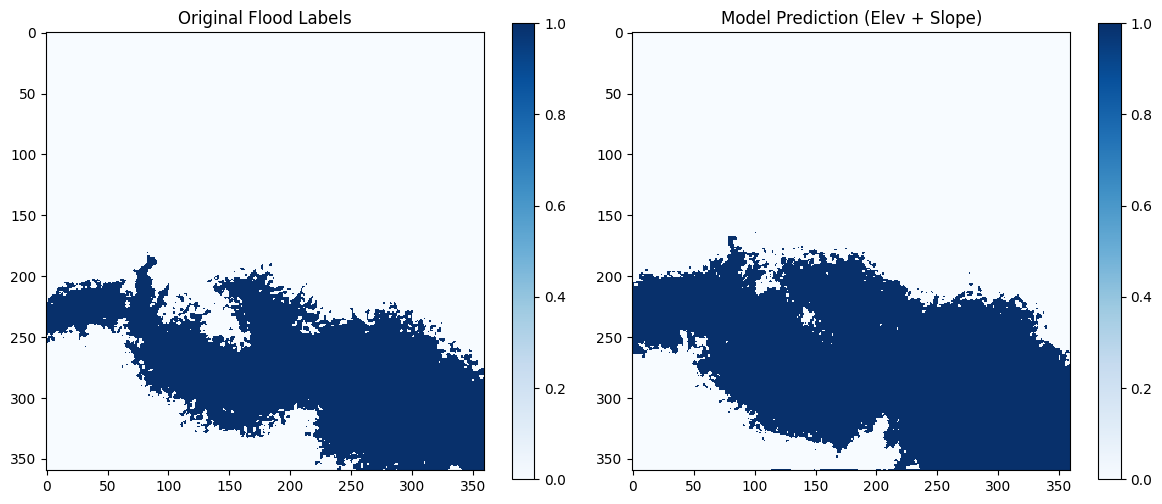

In [ ]:
# Predict on all valid pixels again
model.eval()
with torch.no_grad():
    pred_all = model(torch.tensor(X_combined, dtype=torch.float32)).argmax(dim=1).numpy()

# Fill back into full raster
flat_pred_map = np.full(dem.size, np.nan)
flat_pred_map[valid_mask] = pred_all
predicted_map = flat_pred_map.reshape(dem.shape)

# Visualize
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(labels, cmap='Blues', interpolation='none')
plt.title("Original Flood Labels")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(predicted_map, cmap='Blues', interpolation='none')
plt.title("Model Prediction (Elev + Slope)")
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
!pip install folium
!pip install pillow

import folium
from PIL import Image


In [ ]:
# Normalize predicted map to 0–255 for image export
norm_pred = np.nan_to_num(predicted_map, nan=0)
img_array = (norm_pred * 255 / norm_pred.max()).astype(np.uint8)

# Create a PIL image
img = Image.fromarray(img_array)
img.save("flood_prediction.png")


In [ ]:
from rasterio.transform import xy

# Get lat/lon corners of the image from raster transform
top_left = xy(transform, 0, 0, offset='ul')       # (lon, lat)
bottom_right = xy(transform, dem.shape[0], dem.shape[1], offset='lr')

bounds_latlon = [
    [top_left[1], top_left[0]],        # [[lat_min, lon_min],
    [bottom_right[1], bottom_right[0]]  # [lat_max, lon_max]]
]



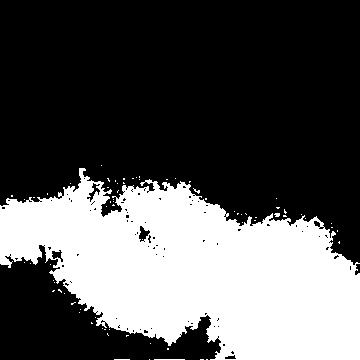

In [ ]:
# Center of the map
center_lat = (bounds_latlon[0][0] + bounds_latlon[1][0]) / 2
center_lon = (bounds_latlon[0][1] + bounds_latlon[1][1]) / 2

# Create Folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')

# Add raster overlay
folium.raster_layers.ImageOverlay(
    name="Flood Prediction",
    image="flood_prediction.png",
    bounds=bounds_latlon,
    opacity=0.6,
    interactive=True,
    cross_origin=False
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Show map
m
